# Skin Cancer Classification Using Convolutional Neural Networks
## Problem Statement
  
In this case study, we have been given a set of images for 9 different skin cancer types.
  
The objective is to develop a Convolutional Neural Network (CNN) to accurately predict the class corresponding to each image.

In [ ]:
# Importing the required libraries
import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt, random as rn, seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

#deep learning libraraies
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
def read_data(directory, mode = 'none'):
  """
  This function reads the images of a directory and returns them with their labels
  images are returned in 'data' array
  labels are returned in 'labels' list
  """
  data = []
  labels = []

  for cancer in cancer_list:
    if  mode == 'with augmentor':
      path = directory + cancer +'/output'
    else: # no augmentor
      path = directory + cancer +'/'
    cancer_label = cancer
    for img in tqdm(os.listdir(path)):
      img_path = os.path.join(path, img)
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, (img_height, img_width))

      data.append(np.array(img))
      labels.append(cancer_label)
  return data, labels


def train_val_data_prep(data, labels, mode = 'none'):
  """
  This function takes data (images as array of 0-255 values), and their labels, and
  outputs below, using train_test_split:
  - x_train_nn, x_val_nn both between (0, 1)
  - y_train_nn, y_val_nn both one hot encoded 
  """
  x_train = np.array(data).astype('float32')
  x_train /= 255.0
  if mode == 'with augmentor':
    y_train = le.transform(labels)
  else:
    y_train = le.fit_transform(labels)
  x_train_nn, x_val_nn, y_train_nn, y_val_nn = train_test_split(x_train, y_train, 
                                                                test_size = 0.2, 
                                                                shuffle = True, 
                                                                stratify = y_train, 
                                                                random_state = 123)
  y_train_nn = to_categorical(y_train_nn)
  y_val_nn = to_categorical(y_val_nn)
  return x_train_nn, x_val_nn, y_train_nn, y_val_nn

def create_cnn_model(mode = 'none'):
  """
  This function creates a CNN with:
    - first conv. layer with 32 filters
    - second conv. layer with 64 filters
    - third convolution layer with 128 filters
    - a dense layer with 256 neurons
    - a final softmax layer for the output
  """
  filter_size = 4
  model = Sequential()

  if mode == 'kr_aug':
    model.add(layers.RandomFlip(input_shape = input_shape))
    model.add(layers.RandomRotation(factor=0.33, 
                                    fill_mode='reflect', 
                                    interpolation='bilinear'))
    model.add(layers.RandomZoom(height_factor=0.2, 
                                width_factor=0.2, 
                                fill_mode='reflect', 
                                interpolation='bilinear'))

    model.add(Conv2D(32, kernel_size=(filter_size, filter_size), activation='relu'))

  else:
    model.add(Conv2D(32, kernel_size=(filter_size, filter_size), activation='relu', input_shape=input_shape))
  
  model.add(BatchNormalization())
  model.add(Conv2D(32, kernel_size=(filter_size, filter_size), 
                   activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(4, 4)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(filter_size, filter_size), 
                   activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size=(filter_size, filter_size), 
                   activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(filter_size, filter_size), 
                   activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dropout(0.5))

  # softmax layer
  model.add(Dense(num_classes, activation='softmax'))

  return model

def plot_cnn_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

def testset_accuracy_calc(model):
  """
  This function calculates accuracy of a model on the test dataset
  """
  y_pred = model.predict(x_test)
  sum_correct = 0.0
  for i in range(y_pred.shape[0]):
    y_pred_temp = list(y_pred[i])
    y_test_temp = list(y_test[i])
    if y_test_temp.index(max(y_test_temp)) == y_pred_temp.index(max(y_pred_temp)):
      sum_correct += 1.0
  test_accuracy = sum_correct / y_pred.shape[0]
  return test_accuracy


In [ ]:
root_path = '/content/gdrive/MyDrive/'
img_height = 180
img_width = 180
batch_size = 32
input_shape = (img_height, img_width, 3)
num_aug_imgs = 500 # number of image samples created by Augmentor, for every class

## Importing the dataset of the cancer images along with their labels

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir(root_path)

!mkdir data

!unzip -q CNN_assignment.zip -d data/

root_path += 'data/'
os.chdir(root_path)

data_folder = os.listdir(".")[0]
root_path += data_folder + '/'
os.chdir(root_path)

The dataset in each Train and Test directory, contains images in 9 folders corresponding to different cancer types. The images in each folder are of the type with the name of the folder.

In [ ]:
# Creating the Training path and Test path
train_dir = root_path + 'Train/' # train data path (directory)
test_dir = root_path + 'Test/'   # test data path (directory)
os.chdir(train_dir)

### Ordered frequency of the images per each cancer type

In [ ]:
cancer_list = os.listdir(train_dir)
img_cnt = []
for dirname, _, filenames in os.walk(train_dir):
  if len(filenames) > 0: # to exclude main /Train directory
    img_cnt.append(len(filenames))

train_classes_df = pd.DataFrame(zip(cancer_list, img_cnt), 
                                columns = ['cancer name', '#images'])
train_classes_df.sort_values(by='#images', ascending = False, inplace=True)
train_classes_df

,cancer name,#images
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


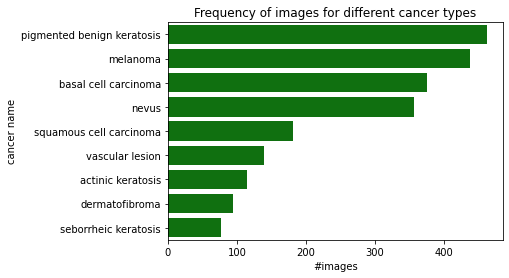

In [ ]:
sns.barplot(x='#images', 
            y='cancer name', 
            data=train_classes_df, 
            color='g').set(title='Frequency of images for different cancer types')
plt.show()

As can be seen, the 'pigmented benign keratosis' and 'melanoma' are the prevalent cancer types, which contain 462 and 438 images, respectively.  
On the other hand, 'seborrheic keratosis' cancer type has the least number of images, i.e. 77.  
This means that the dataset is imbalanced, which will be dealt with, using 2 different types of data augmentation techniques below, later:
- Keras Layers
- Augmentor library
  
  
Now reading (importing) the images corresponding to train set, and then the test set images, all along with their labels.

In [ ]:
train_data, train_labels = read_data(train_dir)

100%|██████████| 139/139 [00:01<00:00, 70.88it/s]


In [ ]:
test_data, test_labels = read_data(test_dir)

100%|██████████| 3/3 [00:00<00:00, 85.98it/s]


In [ ]:
train_set_shape = np.shape(train_data)
print('shape of the train dataset: ', train_set_shape)
print('number of train images (samples):', train_set_shape[0])

shape of the train dataset:  (2239, 180, 180, 3)
number of train images (samples): 2239


In [ ]:
test_set_shape = np.shape(test_data)
print('shape of the test dataset: ', test_set_shape)
print('number of test images (samples):', test_set_shape[0])

shape of the test dataset:  (118, 180, 180, 3)
number of test images (samples): 118


## Visualizing 1 random image from each cancer type

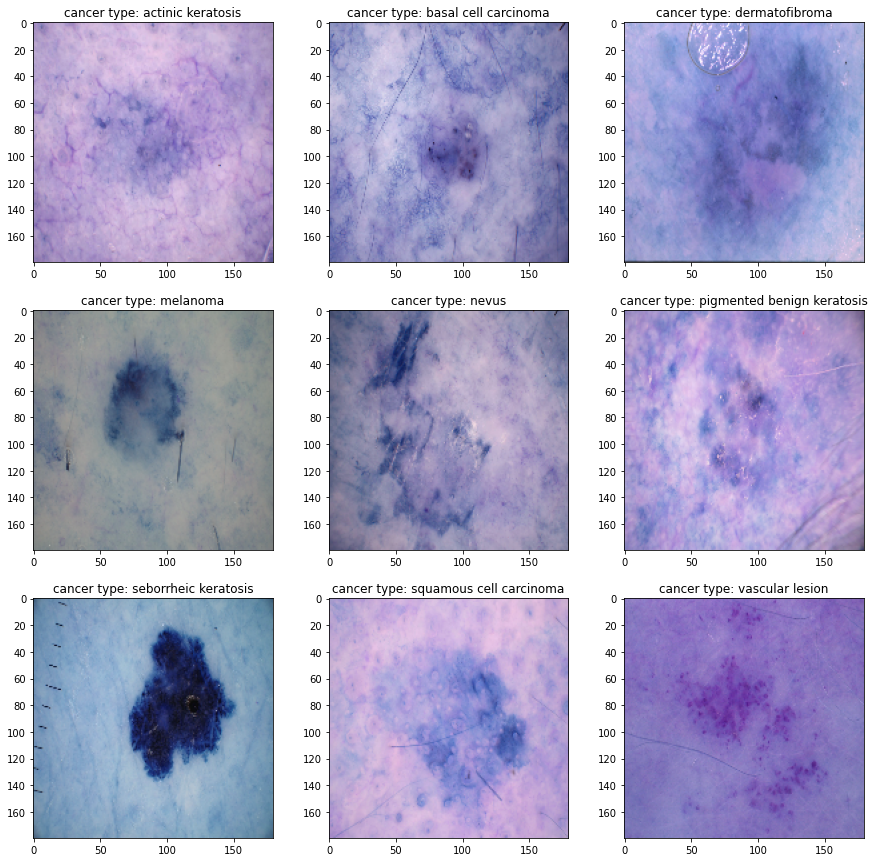

In [ ]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

cnt = 0
start = cnt
end = img_cnt[cnt]

for i in range(3):
    for j in range(3):
        rn_num = rn.randint(start, end)
        ax[i,j].imshow(train_data[rn_num])
        ax[i,j].set_title('cancer type: ' + train_labels[rn_num])
        start += img_cnt[cnt]
        if cnt+1 < len(img_cnt):
          end += img_cnt[cnt+1]
        cnt += 1
plt.savefig('cancers_images.png')
plt.show()

# Data Preparation
  
  
The function train_val_data_prep is used to:
- divide the values of the array of x_train by 255 to have values within (0, 1).
- the labels are first label encoded.
- then train_test_split is used to get the train and validation sets for CNN.
- then the train and validation label encoded y's are one hot encoded to be considered as the output of the CNN.

In [ ]:
le = LabelEncoder()

x_train_nn, x_val_nn, y_train_nn, y_val_nn = train_val_data_prep(train_data, train_labels)

x_test and y_test are also processed in a similar manner to above.

In [ ]:
x_test = np.array(test_data).astype('float32')
x_test /= 255.0
print('shape of x_test: ', x_test.shape)

shape of x_test:  (118, 180, 180, 3)


In [ ]:
y_test = le.transform(test_labels)
y_test = to_categorical(y_test)
print('shape of y_test: ', y_test.shape)

shape of y_test:  (118, 9)


# Model Building and Evaluation
  
Three models are developed:
- Base model: which uses the original train images for training the CNN.
- Keras augmented model: which uses keras.layers functions for data augmentation for training the CNN.
- Augmented model: which uses the newly created images with the Augmentor library, 'along with' the original train images for training the CNN.

In [ ]:
num_classes = y_test.shape[1]
print('number of classes: ', num_classes)

number of classes:  9


### Base model

In [ ]:
# Creating the model
model_base = create_cnn_model()
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 177, 32)      1568      
                                                                 
 batch_normalization (BatchN  (None, 177, 177, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 174, 174, 32)      16416     
                                                                 
 batch_normalization_1 (Batc  (None, 174, 174, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 43, 32)       0         
 )                                                               
                                                        

In [ ]:
# Compiling the model
model_base.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy'])

In [ ]:
# Fitting the model
epochs = 30
history_base = model_base.fit(x_train_nn, y_train_nn, 
                              batch_size=batch_size, 
                              epochs=epochs, 
                              verbose=1, 
                              shuffle=True, 
                              validation_data=(x_val_nn, y_val_nn))

Epoch 1/30
56/56 [==============================] - 17s 115ms/step - loss: 7.6437 - accuracy: 0.2970 - val_loss: 6.9827 - val_accuracy: 0.1674
Epoch 2/30
56/56 [==============================] - 5s 83ms/step - loss: 5.7936 - accuracy: 0.3970 - val_loss: 7.1613 - val_accuracy: 0.1674
Epoch 3/30
56/56 [==============================] - 5s 83ms/step - loss: 4.7805 - accuracy: 0.4149 - val_loss: 5.5547 - val_accuracy: 0.2254
Epoch 4/30
56/56 [==============================] - 5s 83ms/step - loss: 4.1384 - accuracy: 0.4176 - val_loss: 7.1109 - val_accuracy: 0.1183
Epoch 5/30
56/56 [==============================] - 5s 84ms/step - loss: 3.6109 - accuracy: 0.4266 - val_loss: 4.7145 - val_accuracy: 0.2121
Epoch 6/30
56/56 [==============================] - 5s 82ms/step - loss: 3.2766 - accuracy: 0.4495 - val_loss: 4.6343 - val_accuracy: 0.3080
Epoch 7/30
56/56 [==============================] - 5s 83ms/step - loss: 2.9318 - accuracy: 0.4835 - val_loss: 3.1732 - val_accuracy: 0.3103
Epoch 8/30


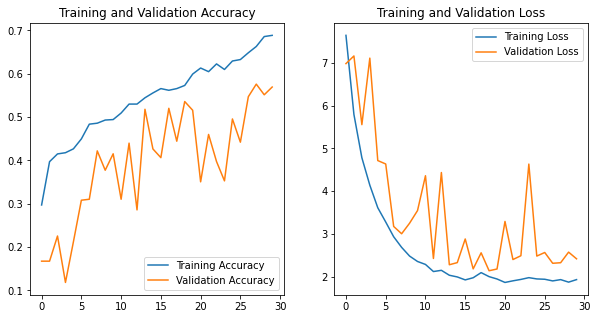

In [ ]:
plot_cnn_performance(history_base)

In [ ]:
model_name = ['base model']
train_acc = [history_base.history['accuracy'][-1]]
val_acc = [history_base.history['val_accuracy'][-1]]
diff_acc = [train_acc[-1] - val_acc[-1]]
testset_acc = [testset_accuracy_calc(model_base)]

print('model name:', model_name[-1])
print('train accuracy:', round(train_acc[-1]*100.0, 2), '%')
print('validation accuracy:', round(val_acc[-1]*100.0, 2), '%')
print('difference between train accuracy and validation accuracy:', round(diff_acc[-1]*100.0, 2), '%')
print('accuracy on the test dataset:', round(testset_acc[-1]*100.0, 2), '%')

4/4 [==============================] - 1s 130ms/step
model name: base model
train accuracy: 68.84 %
validation accuracy: 56.92 %
difference between train accuracy and validation accuracy: 11.92 %
accuracy on the test dataset: 41.53 %


As can be seen, there is a huge gap between training accuracy and validation accuracy (printed above). This means the model is overfitted, which seems to be due to class imbalance and structure of the CNN. The class imbalance is further dealt with in 2 ways below in the 2 later models developed:
- the functions within keras.layers are utilised in order to perform data augmentation.
- the Augmentor library is used in order to create new set of images to be added to the original training images.
  
## Keras augmented model

In [ ]:
# Creating the model
model_krag = create_cnn_model(mode = 'kr_aug') # krag: augmented by keras.layers functions
model_krag.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 177, 177, 32)      1568      
                                                                 
 batch_normalization_5 (Batc  (None, 177, 177, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 174, 174, 32)     

In [ ]:
# Compiling the model
model_krag.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy'])

In [ ]:
# Fitting the model
epochs = 30
history_krag = model_krag.fit(x_train_nn, y_train_nn, 
                              batch_size=batch_size, 
                              epochs=epochs, 
                              verbose=1, 
                              shuffle=True, 
                              validation_data=(x_val_nn, y_val_nn))

Epoch 1/30
56/56 [==============================] - 8s 121ms/step - loss: 7.8090 - accuracy: 0.3043 - val_loss: 6.9902 - val_accuracy: 0.1674
Epoch 2/30
56/56 [==============================] - 7s 118ms/step - loss: 5.7194 - accuracy: 0.3534 - val_loss: 6.4028 - val_accuracy: 0.2344
Epoch 3/30
56/56 [==============================] - 6s 115ms/step - loss: 4.8096 - accuracy: 0.3841 - val_loss: 5.9850 - val_accuracy: 0.2076
Epoch 4/30
56/56 [==============================] - 6s 104ms/step - loss: 4.0844 - accuracy: 0.4137 - val_loss: 6.3870 - val_accuracy: 0.2746
Epoch 5/30
56/56 [==============================] - 6s 104ms/step - loss: 3.5678 - accuracy: 0.4294 - val_loss: 4.2840 - val_accuracy: 0.2500
Epoch 6/30
56/56 [==============================] - 7s 117ms/step - loss: 3.0931 - accuracy: 0.4461 - val_loss: 4.2042 - val_accuracy: 0.2388
Epoch 7/30
56/56 [==============================] - 6s 103ms/step - loss: 2.8673 - accuracy: 0.4394 - val_loss: 3.2598 - val_accuracy: 0.3973
Epoch 

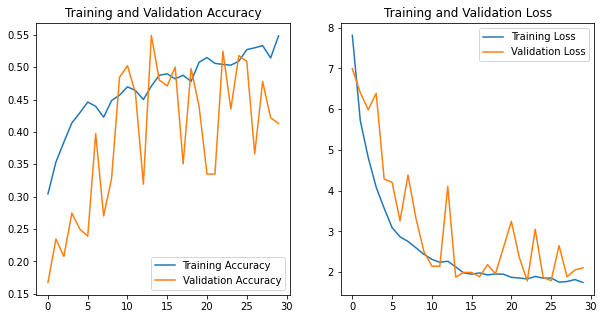

In [ ]:
plot_cnn_performance(history_krag)

In [ ]:
model_name.append('keras augmented model')
train_acc.append(history_krag.history['accuracy'][-1])
val_acc.append(history_krag.history['val_accuracy'][-1])
diff_acc.append(train_acc[-1] - val_acc[-1])
testset_acc.append(testset_accuracy_calc(model_krag))

print('model name:', model_name[-1])
print('train accuracy:', round(train_acc[-1]*100.0, 2), '%')
print('validation accuracy:', round(val_acc[-1]*100.0, 2), '%')
print('difference between train accuracy and validation accuracy:', round(diff_acc[-1]*100.0, 2), '%')
print('accuracy on the test dataset:', round(testset_acc[-1]*100.0, 2), '%')

4/4 [==============================] - 0s 16ms/step
model name: keras augmented model
train accuracy: 54.83 %
validation accuracy: 41.29 %
difference between train accuracy and validation accuracy: 13.54 %
accuracy on the test dataset: 37.29 %


As can be seen, the difference between training accuracy and validation accuracy is still high (as printed above). This means the model is still overfit due to this gap and the structure of the CNN.
  
### Creating new images by Augmentor, and then preparing the training and validation datasets for the Augmented model

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import Augmentor

Creating new images for each cancer type

In [ ]:
for cancer_type in cancer_list:
  path = train_dir + cancer_type
  augmentor = Augmentor.Pipeline(path)
  augmentor.flip_left_right(probability=0.2)
  augmentor.flip_top_bottom(probability=0.2)
  augmentor.rotate(probability=0.8, max_left_rotation=20, max_right_rotation=20)
  augmentor.sample(num_aug_imgs)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4E60159C10>: 100%|██████████| 500/500 [00:20<00:00, 24.04 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4E6003ECD0>: 100%|██████████| 500/500 [00:22<00:00, 22.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4E603ABE10>: 100%|██████████| 500/500 [00:23<00:00, 21.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4E76525650>: 100%|██████████| 500/500 [01:47<00:00,  4.65 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F4EDE558850>: 100%|██████████| 500/500 [01:18<00:00,  6.39 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4E761C4910>: 100%|██████████| 500/500 [00:19<00:00, 25.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4E60FE5550>: 100%|██████████| 500/500 [00:46<00:00, 10.66 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4E60FE5550>: 100%|██████████| 500/500 [00:19<00:00, 25.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4EDF5D1850>: 100%|██████████| 500/500 [00:19<00:00, 25.97 Samples/s]


In [ ]:
# importing the new images produced by Augmentor
train_data_aug, train_labels_aug = read_data(train_dir, mode = 'with augmentor')

100%|██████████| 500/500 [00:02<00:00, 166.71it/s]


In [ ]:
# adding the original train images to the newly produced images
train_data_aug += train_data
train_labels_aug += train_labels

Assessing the number of images within each cancer type

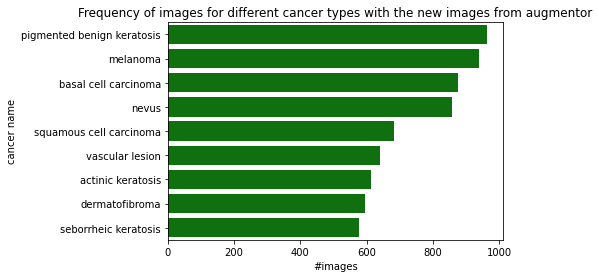

In [ ]:
train_classes_aug_df = train_classes_df.copy()
train_classes_aug_df['#images'] = train_classes_aug_df['#images'].apply(lambda x : x + num_aug_imgs)
sns.barplot(x='#images', 
            y='cancer name', 
            data=train_classes_aug_df, 
            color='g').set(title='Frequency of images for different cancer types with the new images from augmentor')
plt.show()

In [ ]:
# preparing the train and validation data from the available data and labels
x_train_nn_aug, x_val_nn_aug, y_train_nn_aug, y_val_nn_aug = train_val_data_prep(train_data_aug, train_labels_aug, 
                                                                                 mode = 'with augmentor')

### Augmented model

In [ ]:
# Creating the model
model_aug = create_cnn_model()
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 177, 177, 32)      1568      
                                                                 
 batch_normalization_10 (Bat  (None, 177, 177, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 174, 174, 32)      16416     
                                                                 
 batch_normalization_11 (Bat  (None, 174, 174, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                      

In [ ]:
# Compiling the model
model_aug.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [ ]:
# Fitting the model
epochs = 30
history_aug = model_aug.fit(x_train_nn_aug, y_train_nn_aug, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            verbose=1, 
                            shuffle=True, 
                            validation_data=(x_val_nn_aug, y_val_nn_aug))

Epoch 1/30
169/169 [==============================] - 16s 87ms/step - loss: 6.2018 - accuracy: 0.3018 - val_loss: 8.7983 - val_accuracy: 0.1209
Epoch 2/30
169/169 [==============================] - 14s 81ms/step - loss: 3.6595 - accuracy: 0.3441 - val_loss: 4.7008 - val_accuracy: 0.1840
Epoch 3/30
169/169 [==============================] - 14s 81ms/step - loss: 2.8482 - accuracy: 0.3719 - val_loss: 4.3308 - val_accuracy: 0.2404
Epoch 4/30
169/169 [==============================] - 14s 81ms/step - loss: 2.4184 - accuracy: 0.3882 - val_loss: 6.7310 - val_accuracy: 0.1588
Epoch 5/30
169/169 [==============================] - 14s 84ms/step - loss: 2.1571 - accuracy: 0.4111 - val_loss: 2.2705 - val_accuracy: 0.3746
Epoch 6/30
169/169 [==============================] - 14s 83ms/step - loss: 1.9874 - accuracy: 0.4522 - val_loss: 1.9446 - val_accuracy: 0.4525
Epoch 7/30
169/169 [==============================] - 14s 84ms/step - loss: 1.9962 - accuracy: 0.4546 - val_loss: 3.0731 - val_accuracy:

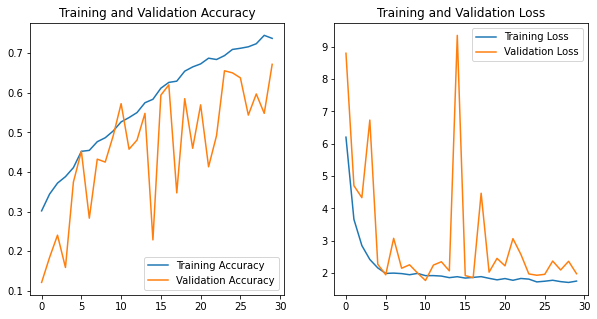

In [ ]:
plot_cnn_performance(history_aug)

In [ ]:
model_name.append('Augmented model')
train_acc.append(history_aug.history['accuracy'][-1])
val_acc.append(history_aug.history['val_accuracy'][-1])
diff_acc.append(train_acc[-1] - val_acc[-1])
testset_acc.append(testset_accuracy_calc(model_aug))

print('model name:', model_name[-1])
print('train accuracy:', round(train_acc[-1]*100.0, 2), '%')
print('validation accuracy:', round(val_acc[-1]*100.0, 2), '%')
print('difference between train accuracy and validation accuracy:', round(diff_acc[-1]*100.0, 2), '%')
print('accuracy on the test dataset:', round(testset_acc[-1]*100.0, 2), '%')

4/4 [==============================] - 0s 27ms/step
model name: Augmented model
train accuracy: 73.77 %
validation accuracy: 67.21 %
difference between train accuracy and validation accuracy: 6.56 %
accuracy on the test dataset: 49.15 %


As can be seen, the difference between training accuracy and validation accuracy has reduced to the value printed above. So this implies that the extent of overfit of the model is less than the previous 2 models. This means that using Augmentor to produce new images and adding them to the original train images has improved the performance of the CNN.
  
### Models Summary
  
The performance of the developed models are compared and ranked as below.

In [ ]:
models_compare = pd.DataFrame(zip(model_name, train_acc, val_acc, diff_acc, testset_acc), 
                              columns=['Model', 'Train accuracy', 'Validation accuracy', 
                                       'diff train&val acc', 'Test set acc'])
models_compare

,Model,Train accuracy,Validation accuracy,diff train&val acc,Test set acc
0,base model,0.688442,0.569196,0.119246,0.415254
1,keras augmented model,0.548297,0.412946,0.135351,0.372881
2,Augmented model,0.737711,0.672107,0.065604,0.491525


In [ ]:
print('model with the highest train accuracy:', 
      list(models_compare.sort_values(by='Train accuracy', ascending=False)['Model'])[0])
print('model with the lowest difference between train and validation accuracy:', 
      list(models_compare.sort_values(by='diff train&val acc', ascending=True)['Model'])[0])
print('model with the highest test set accuracy:', 
      list(models_compare.sort_values(by='Test set acc', ascending=False)['Model'])[0])

model with the highest train accuracy: Augmented model
model with the lowest difference between train and validation accuracy: Augmented model
model with the highest test set accuracy: Augmented model


As can be seen, the 'Augmentor based model' has the lowest train accuracy, the lowest test set accuracy, and the lowest difference between train and validation accuracies. This is due to the fact that this model has been trained based on more balanced set of data from these 9 classes, and hence has shown a better performance during training, validation, and test. Therefore, this model can be considered for production.
  
#### Next Steps:
- To further improve the structure of the CNN
- To further increase the number of samples produced by Augmentor
  
# Acknowledgements
- I would like to acknowledge the feedback, support and dataset provision by [upGrad](https://www.upgrad.com/gb) and The [International Institute of Information Technology (IIIT), Bangalore](https://www.iiitb.ac.in/).  
- Also, I would like to express my gratitude to [Nishan Ali](https://www.linkedin.com/in/nishan-ali-826552166/) for providing clarification and guidance to carry out this project.   
- Furthermore, the valuable feedback from [Dr Tayeb Jamali](https://www.linkedin.com/in/tayeb-jamali-b1a10937/) is highly appreciated.
